# Image Classification on Single Image
We have trained several acceptable models on ILSVRC2012 and mini ImageNet dataset. This jupyter notebook is the visualized interface to predict a single image given by users. We strongly recommend you to install following requirements:
* python >= 3.6
* tensorflow >= 2.0.0
* numpy
* opencv-python
* matplotlib

If you have the requirement of applying seam carving during the test time, you also need:
* tqdm >= 4.42.0

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt

import constants as c

## Datasets and Models
Every model in current project was trained on either mini ImageNet dataset or ILSVRC 2012 dataset.

ILSVRC 2012 dataset is the dataset used in ImageNet Large Scale Visual Recognition Competition 2012, consists of over 1.2 million high-resolution images belonging to 1,000 categories. Concretely, there are 1,281,167 training images, 50,000 validation images and 100,000 test images.

Mini ImageNet dataset is the subset of ImageNet dataset, only 60,000 images of 100 categories in total. We randomly divided them into three subsets: 50,000 images for training, 5,000 images for validation and 5,000 images for testing. Since the limitation of hardwares, most models were trained on mini ImageNet dateset rather than ILSVRC 2012.

We mainly implemented 2 kinds of networks: AlexNet and ResNet v2, here is the available model list:

|model name|dataset|categories|top-1 val err(%)|top-5 val err(%)|top-1 test err(%)|top-5 test err(%)|
|-|-|-|-|-|-|-|
|AlexNet|miniImageNet|100|38.00|19.12|34.14|12.62|
|AlexNet-BN|miniImageNet|100|31.52|11.46|31.20|11.80|
|ZFNet-BN|miniImageNet|100|29.42|5.47|24.14|7.94|
|ResNetV2-18|miniImageNet|100|21.60|6.42|22.04|6.36|
|cd-ResNetV2-18|miniImageNet|100|20.32|6.36|20.98|6.72|
|cd-old-ResNetV2-18|miniImageNet|100|20.54|6.22|21.00|6.58|
|ResNetSE-18|miniImageNet|100|19.98|6.38|22.08|6.62|
|ResNetV2-50|miniImageNet|100|19.38|5.54|20.22|5.48|
|cd-ResNetV2-50|miniImageNet|100|18.42|5.10|19.04|5.22|
|**ResNetSE-50**|**miniImageNet**|**100**|**16.36**|**4.80**|**16.78**|**4.78**|
|ocd-ResNetV2-18|ILSVRC2012|1,000|27.52|9.15|---|---|
|oResNetV2-50|ILSVRC2012|1,000|22.62|6.21|---|---|
|**ocd-ResNetV2-50**|**ILSVRC2012**|**1,000**|**21.95**|**5.81**|**---**|**---**|
|Average|ILSVRC2012|1,000|21.14|5.50|---|---|

**Note:**
* 'Average' model returns the average predictions of 'oResNetV2-50' and 'ocd-ResNetV2-50'. The notebook cannot use this model to predict, please run ```./test_single_image.py``` instead.
* For ILSVRC 2012, labels were never publicly released for the test set, so only error rates on validation set were reported.
* All error rates were computed with 10-crop and no seam carving.
* The learning rate was divided by 10 manually when convergence, except which a 'cd' in their names, they were applied cosine decay strategy during the training time.
* Due to some historical reasons, 'cd-old-ResNetV2-18' trained on miniImageNet but used the numeric features of ILSVRC 2012 dataset.

In [2]:
# get the model by name, don't need to modify
def load_model(name='ocd-ResNetV2-50'):
    if name[0]=='o' or 'old' in name:
        c.mean, c.std, c.eigval, c.eigvec = c.mean_m, c.std_m, c.eigval_m, c.eigvec_m # mini imageNet
    else:
        c.mean, c.std, c.eigval, c.eigvec = c.mean_o, c.std_o, c.eigval_o, c.eigvec_o # ILSVRC 2012
    
    c.num_class = 1000 if name[0]=='o' else 100
    
    if 'ResNetV2-50' in name:
        from models.ResNetV2_50 import ResNet_v2_50
        model = ResNet_v2_50()
    elif 'ResNetV2-18' in name:
        from models.ResNetV2_18 import ResNet_v2_18
        model = ResNet_v2_18()
    elif 'ResNetSE-18' in name:
        from models.ResNetSE_18 import ResNetSE_18
        model = ResNetSE_18()
    elif 'ResNetSE-50' in name:
        from models.ResNetSE_50 import ResNetSE_50
        model = ResNetSE_50()
    elif 'ZFNet' in name:
        from models.ZFNet import ZFNet
        model = ZFNet()
    elif name=='AlexNet-BN':
        from models.AlexNet_bn import AlexNet_BN
        model = AlexNet_BN()
    elif 'AlexNet' in name:
        from models.AlexNet import AlexNet
        model = AlexNet()
    
    model.build(input_shape=(None,) + c.input_shape)
    model.load_weights("./h5/{}.h5".format(name))
    
    return model

In [3]:
# modify the name to load the model
# please put *.h5 file in './h5' directory
model = load_model("ocd-ResNetV2-50")

## Seam Carving(optional)
Seam Carving is an approach to carve an image. An energy map of the image would be computed and then choose a seam with the minimum summation of energy value to carve. For more details please make reference to [Seam Carving for Content-Aware Image Resizing](https://arxiv.org/pdf/1904.08475.pdf).

Traditionally 10-crop would be applied at test time. We first rescaled the image such that the shorter side was of input length 224, then apply the seam carving to make the image 224x224. Make prediction on these 11 images and get the average score.

We tested on "cd-old-ResNetV2-18" model, and got 0.14% increasement of top-5 accuracy if applying seam carving. 

However, there would be much consumption of time, especially the images with great difference in height and width. You can choose whether to apply it or not.

In [4]:
apply_seam_carving = True

## Test Single Image
Please set the ```image_path``` to your own image. The label list is available:
* For mini ImageNet: ```./data/miniImageNet/labels_to_content.txt```, 100 categories.
* For ILSVRC 2012: ```./data/ILSVRC2012/labels_to_content.txt```, 1000 categories.

In [8]:
image_path = "image.jpg"

Seam Carving...


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [01:09<00:00,  2.51it/s]


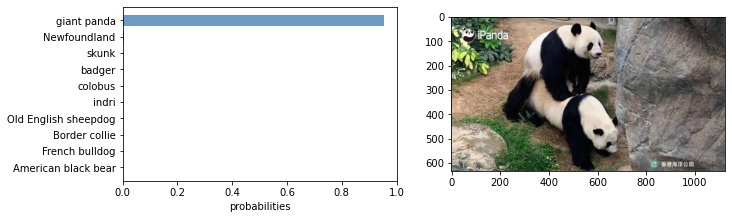

----------------------------------------
Predictions top-10:
0.9551 	 giant panda
0.0042 	 Newfoundland
0.0016 	 skunk
0.0011 	 badger
0.0010 	 colobus
0.0008 	 indri
0.0006 	 Old English sheepdog
0.0006 	 Border collie
0.0006 	 French bulldog
0.0005 	 American black bear
----------------------------------------


In [9]:
# Don't modify this block if you don't know what you are doing

show_top_k = 10
plt.figure(figsize=(10.8, 3.2))

def load_image_multicrop(path):
    image = cv2.imread(path).astype(np.float32)
    plt.subplot(1, 2, 2)
    plt.imshow(image[:,:,::-1] / 255)
    
    from utils.data import rescale_short_edge
    image = rescale_short_edge(image, new_size=256)
    
    from utils.utils import crop_ten
    images = crop_ten(image)
    
    if apply_seam_carving == True:
        from utils import seam_carving
        print("Seam Carving...", flush=True)
        images.append(seam_carving.carve(image))

    image = np.array(images, dtype=np.float32)
    
    original_image = image.copy()

    for i in range(3):
        image[..., i] = (image[..., i] - c.mean[i]) / c.std[i]
    
    return image, original_image


image, original_image = load_image_multicrop(image_path)
predict = model(image, training=False)
prediction = tf.reduce_mean(predict, axis=0)

index_list = np.argpartition(prediction, -show_top_k)[-show_top_k:]
index_list = sorted(index_list, key=lambda x: -prediction[x])

with open("./data/{}/labels_to_content.txt".format("miniImageNet" if c.num_class==100 else "ILSVRC2012")) as f:
    label_dict = np.array(f.read().splitlines())

plt.subplot(1, 2, 1)
plt.barh(range(show_top_k), prediction.numpy()[index_list][::-1], height=0.7, color='steelblue', alpha=0.8)
plt.yticks(range(show_top_k), label_dict[index_list][::-1])
plt.xlabel("probabilities")
plt.xlim(0,1)

plt.show()

print('-' * 40)
print("Predictions top-{:d}:".format(show_top_k))
for lable in index_list:
    print("{:.4f} \t {}".format(prediction[lable], label_dict[lable]))
print('-' * 40)

## Details
The block would show you the predictions of all the 10 (11 if seam carving applied) crops, the final prediction is the average of these below.

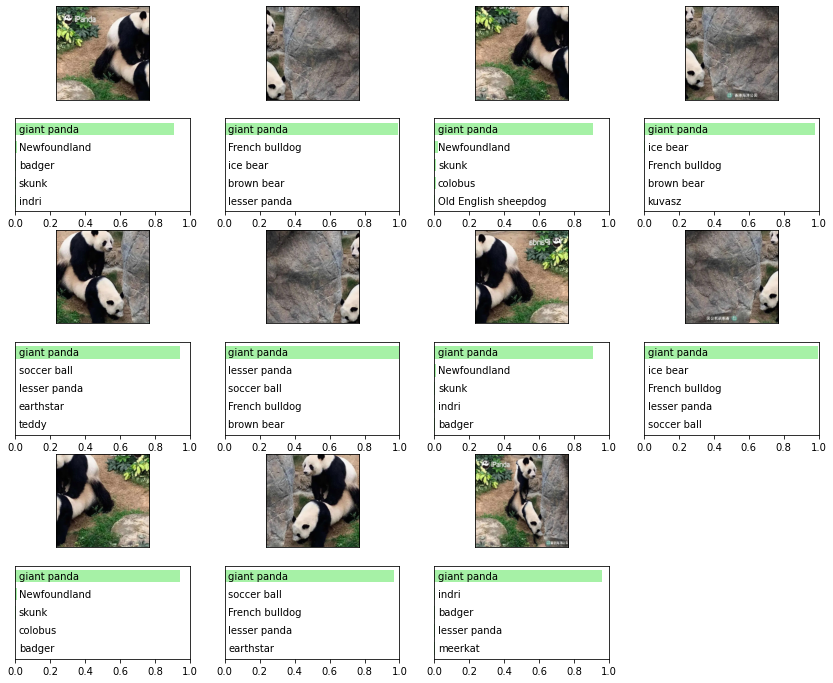

In [10]:
# Don't modify this block if you don't know what you are doing

top_k = show_top_k//2
plt.figure(figsize=(14.4, 12))

for i in range(predict.shape[0]):
    blk = 8 * (i//4) + i%4 + 1
    plt.subplot(6, 4, blk)
    plt.imshow(original_image[i][:,:,::-1] / 255)
    plt.yticks([])
    plt.xticks([])

    prediction = predict[i]
    index_list = np.argpartition(prediction, -top_k)[-top_k:]
    index_list = sorted(index_list, key=lambda x: -prediction[x])

    plt.subplot(6, 4, blk+4)
    b = plt.barh(range(top_k), prediction.numpy()[index_list][::-1], height=0.7, color='lightgreen', alpha=0.8)
    labels = label_dict[index_list][::-1]
    cnt = 0
    for rect in b:
        plt.text(0.02, rect.get_y()+rect.get_height()/2, labels[cnt], ha='left', va='center')
        cnt += 1
    plt.yticks([])
    plt.xlim(0,1)

plt.show()

End.